In [1]:
import numpy as np
from scipy import linalg, sparse, stats
from sksparse import cholmod
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from optfunctions import *

%matplotlib inline

## PART 1.4
### Create test problem:

Test problem:

$x \in \mathbb{R}^n,\\ A \in \mathbb{R}^{n \times m}$ with 15% non-zero elements, $A_{ij} \sim N(0,1), \\ m=round(\beta n),\, 0 < \beta < 1$. $ \\ H = MM^\top + \alpha I$ where $\\ M \in \mathbb{R}^{n \times n}$ has 15% non-zero elements, $M_{i,j} \sim N(0,1)$.

Let $x_i \sim N(0,1)$ for $i=1,2,...,n$.

Let $\lambda_i \sim N(0,1)$ for $i=1,2,...,m$

$b = A^\top x$

$g = A \lambda - H x$



In [2]:
def test_problem(n, alpha, beta, seed=None):
    '''
    create test problem as defined in part 1.4 of the assignment.

    params:
        n:      size of H
        alpha:  regularization parameter
        beta:   parameter determining what percentage of n that m is

    output:
        H:  sparse H
        Hd: dense H
        g:  g
        A:  sparse A
        Ad: dense A
        b:  b
    '''
    rng = np.random.default_rng(seed=seed)
    #rvs = stats.norm(loc=0, scale=1).rvs
    rvs = np.random.standard_normal
    n = int(n)
    m = int(round(beta * n))
    A = sparse.random_array((n,m), density=0.15, format="csc", random_state=rng, data_sampler=rvs)# data_sampler=rvs
    M = sparse.random_array((n,n), density=0.15, format="csc", random_state=rng, data_sampler=rvs)
    H = M @ M.T + alpha * sparse.eye_array(n, format="csc")

    x = np.random.standard_normal(n)
    lambdas = np.random.standard_normal(m)

    b = A.T @ x
    g = A @ lambdas - H @ x

    return H, H.toarray(), g, A, A.toarray(), b

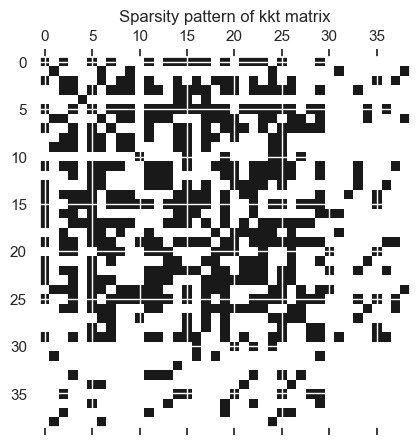

(-2.2271930375505726+0j)


In [3]:
seed = 42
alpha = 0.5
beta = 0.3
n = 30
H, Hd, g, A, Ad, b = test_problem(n, alpha, beta, seed=seed)

KKT, RHS = kkt(H,g,A,b)

#sns.heatmap(KKT.toarray())
#plt.show()

#plt.spy(KKT,markersize=10)
plt.spy(KKT.toarray())
plt.title("Sparsity pattern of kkt matrix")
plt.show()

KKT, RHS = kkt(Hd,g,Ad,b)
print(linalg.eigvals(KKT).min())

## Part 1.5
### testing the solvers on test problem:

In [4]:
seed = 42 # for reproducible results

ns = np.linspace(10,2010,20) #list of sizes of the test problem

alpha = 2  #regularization parameter to increase diagonal in H
beta = 0.7 #proportion of constraints to num variables
#solvers = ["LUdense", "LUsparse", "LDLdense", "LDLsparse", "NullSpace", "RangeSpace"] # uncomment to run with LDLsparse 
solvers = ["LUdense", "RangeSpace", "NullSpace", "LDLdense"]             # uncomment this to run without LDLsparse

times = np.zeros((len(ns),len(solvers)))
obj = np.zeros((len(ns),len(solvers)))

for i, n in enumerate(ns):
    H, Hd, g, A, Ad, b = test_problem(n=n, alpha=alpha, beta=beta, seed=seed)
    xs = np.zeros((len(solvers),len(g)))
    for j, solver in enumerate(solvers):
        if solver == "LUsparse" or solver == "LDLsparse":
            H_mat = H
            A_mat = A
        else:
            H_mat = Hd
            A_mat = Ad 
        try:
            t1 = time.perf_counter()
            x, lambdas = EqualityQPSolver(H_mat,g,A_mat,b,solver)
            t2 = time.perf_counter()
            times[i,j] = t2-t1

            xs[j] = x

            obj[i,j] = 0.5 * x.T @ H @ x + g.T @ x
        except:
            print(f"error with solver: {solver} at iteration: {i}")
            KKT, RHS = kkt(Hd,g,Ad,b)
            #print("most negative eigenval: {:.2f}".format(np.min(linalg.eigvals(KKT))))
            times[i,j] = 0


error with solver: RangeSpace at iteration: 0
error with solver: NullSpace at iteration: 0
error with solver: LDLdense at iteration: 0


c:\Users\Phill\Documents\School\MSc\1. Sem\Constrained Optimization\ASSIGNMENT\02612_git\02612-Project\optfunctions.py:29: LinAlgWarning: Diagonal number 14 is exactly zero. Singular matrix.
  lu_factor = linalg.lu_factor(KKT)


In [5]:
#check if all give same objective
all_same = np.all(np.array([np.allclose(obj[i,:],obj[i,0]) for i in range(1,obj.shape[0])]))
print(all_same)

True


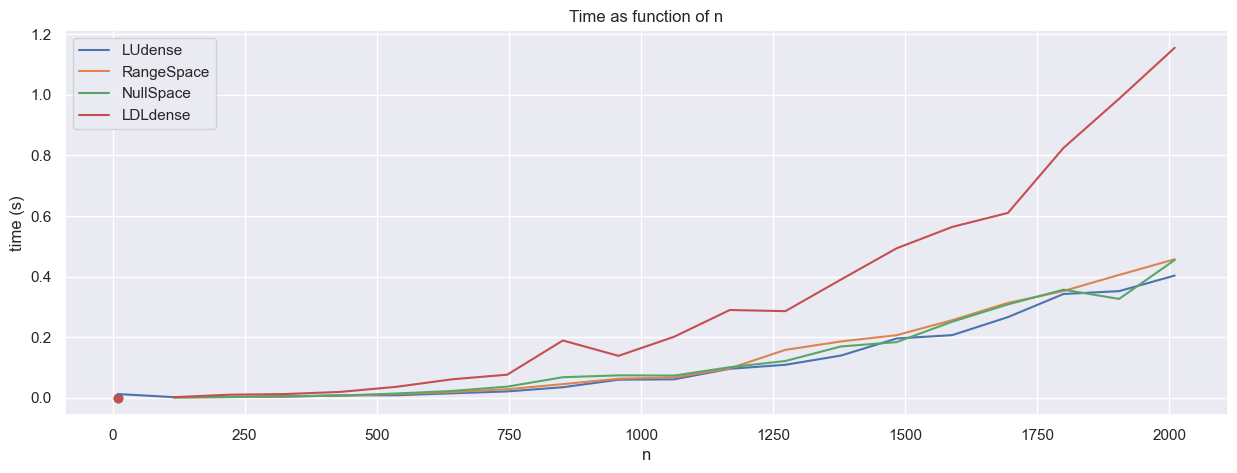

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
for i, solver in enumerate(solvers):
    time_i = times[:,i]
    ax.plot(ns[time_i!=0],time_i[time_i!=0], label=solver)
    ax.scatter(ns[time_i==0], time_i[time_i==0])
    
ax.set_xlabel("n")
ax.set_ylabel("time (s)")
ax.legend()

plt.title("Time as function of n")
plt.show()

## Part 6
### Test solvers on given test problem:

In [7]:
#parse test problem from string:

mat_string = "5.0000 1.8600 1.2400 1.4800 -0.4600 1.8600 3.0000 0.4400 1.1200 0.5200 1.2400 0.4400 3.8000 1.5600 -0.5400 1.4800 1.1200 1.5600 7.2000 -1.1200 -0.4600 0.5200 -0.5400 -1.1200 7.8000"

H = np.fromstring(mat_string, sep=" ").reshape((5,5))

g = np.fromstring("-16.1000 -8.5000 -15.7000 -10.0200 -18.6800", sep=" ")

A = np.ones((5,2))
A[:,0] = -g

b = np.array([15, 1]).astype(np.float64)

#check if problems are parsed correctly:
print("H:")
print(H)
print("\ng:")
print(g)
print("\nA:")
print(A)
print("\nb:")
print(b)

H:
[[ 5.    1.86  1.24  1.48 -0.46]
 [ 1.86  3.    0.44  1.12  0.52]
 [ 1.24  0.44  3.8   1.56 -0.54]
 [ 1.48  1.12  1.56  7.2  -1.12]
 [-0.46  0.52 -0.54 -1.12  7.8 ]]

g:
[-16.1   -8.5  -15.7  -10.02 -18.68]

A:
[[16.1   1.  ]
 [ 8.5   1.  ]
 [15.7   1.  ]
 [10.02  1.  ]
 [18.68  1.  ]]

b:
[15.  1.]


In [8]:
#test different dense solvers on problem:
solvers = ["LUdense", "LDLdense", "NullSpace", "RangeSpace"]
for solver in solvers:
    x, lambdas = EqualityQPSolver(H,g,A,b,solver)
    print(f"{solver}:\n    x: {x}\n    lambdas: {lambdas}")
    opt = (1/2) * x.T @ H @ x + g.T @ x
    print(f"    opt val: {opt}\n")

LUdense:
    x: [0.1757894  0.1510641  0.33873078 0.07843107 0.25598465]
    lambdas: [-0.94366836  0.67133798]
    opt val: -14.241843689169391

LDLdense:
    x: [0.1757894  0.1510641  0.33873078 0.07843107 0.25598465]
    lambdas: [-0.94366836  0.67133798]
    opt val: -14.241843689169391

NullSpace:
    x: [0.1757894  0.1510641  0.33873078 0.07843107 0.25598465]
    lambdas: [-0.94366836  0.67133798]
    opt val: -14.241843689169395

RangeSpace:
    x: [0.1757894  0.1510641  0.33873078 0.07843107 0.25598465]
    lambdas: [-0.94366836  0.67133798]
    opt val: -14.2418436891694



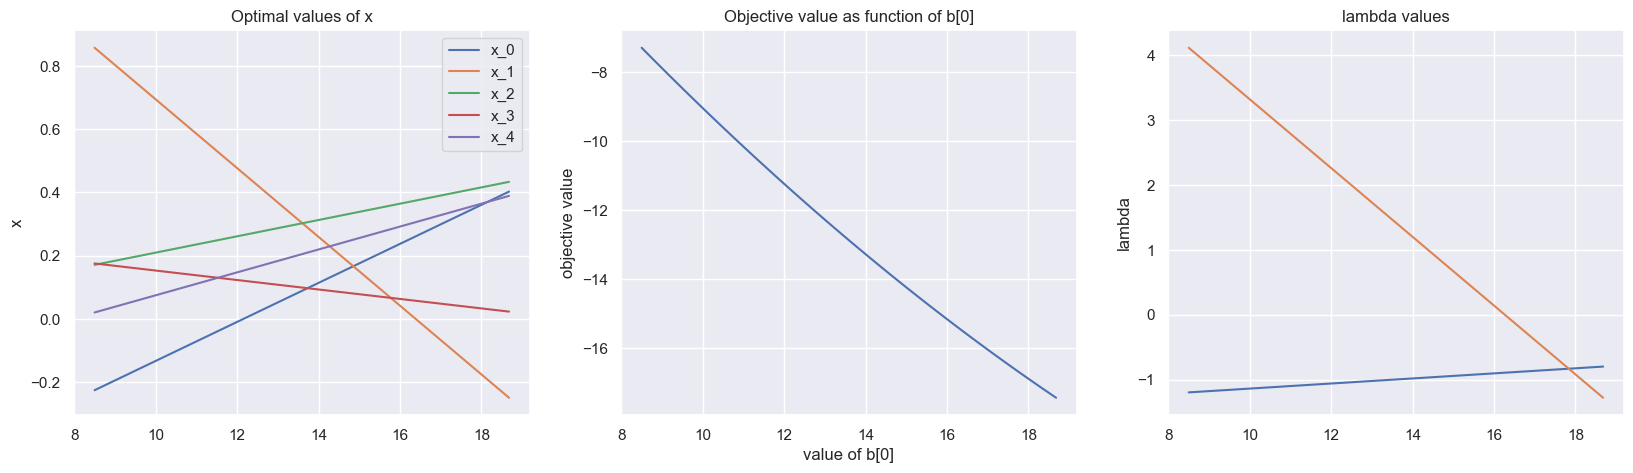

In [9]:
spacing = 100

b0s = np.linspace(8.5, 18.68, spacing) #define range of b[0]
xs = np.zeros((spacing,5))
lambdas_ = np.zeros((spacing,2))
opt = np.zeros(spacing)

for i, b0 in enumerate(b0s):
    b[0] = b0
    x, lambdas = EqualityQPSolver(H,g,A,b,"LUdense")
    xs[i], lambdas_[i] = x, lambdas
    opt[i] = 0.5 * x.T @ H @ x + g.T @ x

fig, axs = plt.subplots(1,3, figsize=(20,5))
for i in range(5):
    axs[0].plot(b0s, xs[:,i], label = f"x_{i}")

axs[0].legend()
axs[0].set_title("Optimal values of x")
#axs[0].set_xlabel("value of b[0]")
axs[0].set_ylabel("x")

axs[1].plot(b0s,opt)
axs[1].set_title("Objective value as function of b[0]")
axs[1].set_xlabel("value of b[0]")
axs[1].set_ylabel("objective value")

for i in range(2):
    axs[2].plot(b0s, lambdas_[:,i], label=f"lambda_{i}")
axs[2].set_title("lambda values")
axs[2].set_ylabel("lambda")
plt.show()
